In [1]:
import numpy as np
from numpy.polynomial import Polynomial
from astropy.io import fits
import os
from funcs import collect_fits_files, separate_fits_files

# Directorycontaining the FITS files
fits_directory = '/home/aaron/Desktop/ZASPE/Spectra/GJ1094/'


In [2]:
fits_files = collect_fits_files(fits_directory,extension="A.fits")
fits_files, ccf_files = separate_fits_files(fits_files)

In [3]:
from funcs import calculate_wavelengths 

wavelengths = calculate_wavelengths(fits_files, fits_directory)
observed_wavelengths = wavelengths 

Shape of wavelengths array: (7, 72, 4096)


In [4]:
import matplotlib.pyplot as plt 

<IPython.core.display.Javascript object>


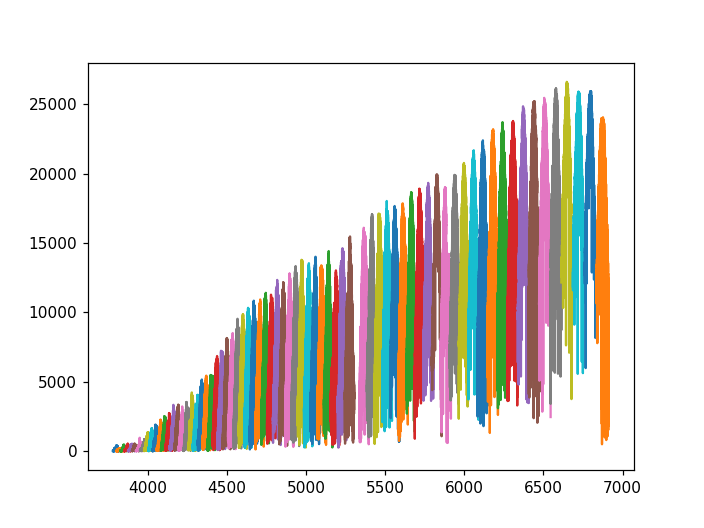

In [5]:
%matplotlib notebook
for order in range(np.shape(wavelengths)[1]):
    plt.plot(wavelengths[0,order],fits.getdata(fits_files[0])[order])
#not blaze corrected

### Blaze fitting

Because lack of the blaze function. 

In [6]:
RV = []
date = []

#here you need to include exoplanets and fit for RV
#https://gallery.exoplanet.codes/tutorials/rv/
# better https://radvel.readthedocs.io/en/latest/quickstartcli.html#example-fit

In [7]:
#get RVs

for fits_file in ccf_files: 
    header = fits.getheader(fits_file)
    RV.append(header["ESO DRS CCF RVC"])
    date.append(header["ESO DRS BJD"])


<IPython.core.display.Javascript object>


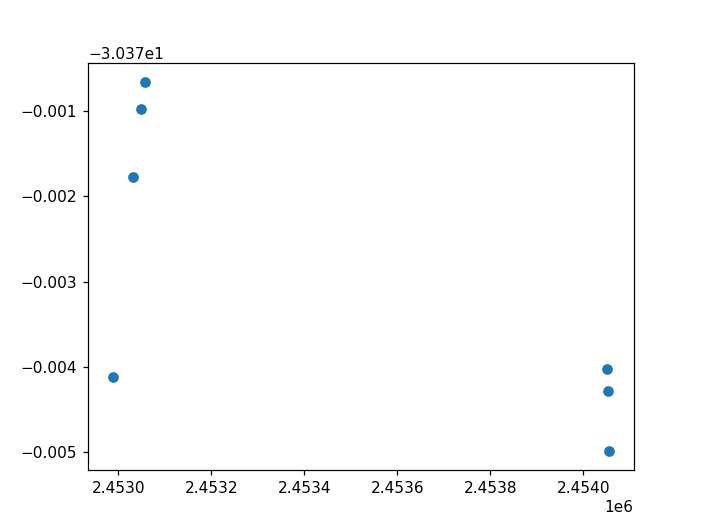

In [8]:
plt.scatter(date,RV)
#plt.ylim(0,40)

In [4]:
from pyutil.pyutil import blazeFit 
from funcs import apply_blaze_correction
maxrms = 0.005

r,b,bj = apply_blaze_correction(observed_wavelengths,fits_files,ccf_files,fits_directory)

  0%|          | 0/7 [00:00<?, ?it/s]

# ---------------------------------------------

In [17]:
l = np.ones(np.shape(wav))
for i in range(len(wav)):
    l[i] = wav[i]*(1+(np.asarray(RV_)[i] + np.asarray(BERV_)[i])/c_km )

<IPython.core.display.Javascript object>


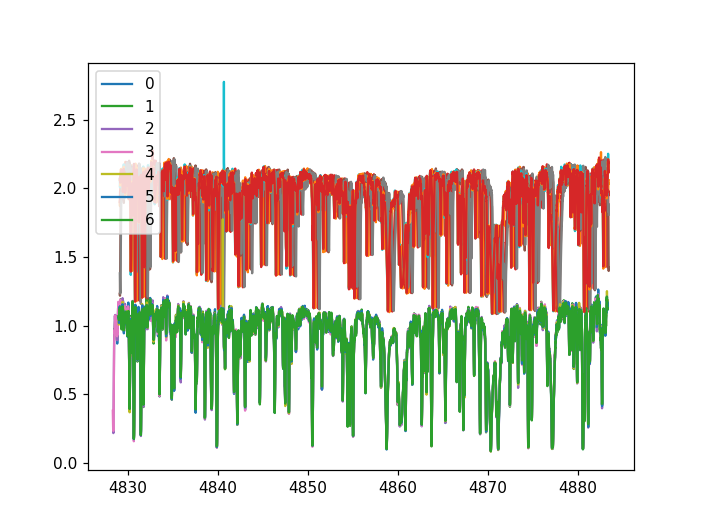

In [18]:
%matplotlib notebook
for i in range(len(wav)):
    plt.plot(l[i][35], flux_blaze_corr[i][35]/np.median(flux_blaze_corr[i][35]),label = str(i)) 
    plt.plot(wav[i][35], 1+flux_blaze_corr[i][35]/np.median(flux_blaze_corr[i][35])) 
plt.legend()

In [ ]:
################################

import re
from funcs import natural_sort_key
import numpy as np
import os
from astropy.io import fits
from numpy.polynomial import Polynomial

def calculate_wavelengths(fits_files, fits_directory):
    
    """
    Calculates the wavelengths corresponding to the pixels and orders in a list of FITS files.

    Args:
        fits_files (list): A list of FITS file names.
        fits_directory (str): The directory path where the FITS files are located.

    Returns:
    wavelengths
        numpy.ndarray: An array of shape (num_nights, num_order, num_pixels) that stores the wavelengths.

    This function reads the FITS files, extracts the necessary information from the FITS headers, and performs
    polynomial fitting to obtain the wavelengths for each pixel and order. The wavelengths are then stored in an array
    and returned.
    """
    

    # Initialize the array to store wavelengths
    d = fits.getdata(fits_files[0])

    num_pixels = np.shape(d)[1]
    num_order = np.shape(d)[0]
    num_nights = len(fits_files)
    wavelengths = np.zeros((num_nights, num_order, num_pixels))

    # Loop over nights
    for i, fits_file in enumerate(fits_files):

        fits_path = os.path.join(fits_directory, fits_file)
        hdr = fits.getheader(fits_path)
        degree_polynomial = hdr['ESO DRS CAL TH DEG LL'] + 1  # plus one because there is zeroth order
        coeffecients_orders = sorted(hdr['ESO DRS CAL TH COEFF LL*'], key=natural_sort_key)
        order_number = int(np.round(len(coeffecients_orders) / degree_polynomial))

        xx = np.arange(num_pixels)

        # Loop over orders
        for order in range(order_number):
            # Get coefficients of the fits headers
            if order == 0:
                idx1 = order
                idx2 = idx1 + degree_polynomial  # might have varying polynomial degrees per night
            else:
                idx1 = idx2
                idx2 = idx2 + degree_polynomial
            if order == 0:
                coeffecients_order = coeffecients_orders[idx1:idx2]
            else:
                coeffecients_order = coeffecients_orders[idx1:idx2]
            coeff = []
            for c in coeffecients_order:
                coeff.append(hdr[c])
            # Obtain wavelength array for night and order
            p = Polynomial(np.asarray(coeff))
            wavelengths[i, order] = p(xx)

    # Check the shape of the wavelengths array
    print("Shape of wavelengths array:", wavelengths.shape)

    return wavelengths



# Initialize the array to store wavelengths
import re
from funcs import natural_sort_key

#get num pix, num_ord, num_nights
d = fits.getdata(fits_files[0])

num_pixels = np.shape(d)[1]
num_order = np.shape(d)[0]
num_nights = len(fits_files)
wavelengths = np.zeros((num_nights, num_order, num_pixels))

#Loop over nights
for i, fits_file in enumerate(fits_files):
    
    fits_path = os.path.join(fits_directory, fits_file)
    hdr = fits.getheader(fits_path)
    degree_polynomial = hdr['ESO DRS CAL TH DEG LL' ]+1  #plus one because there is zeroth order
    coeffecients_orders = sorted(hdr['ESO DRS CAL TH COEFF LL*'], key = natural_sort_key)
    order_number = int(np.round(len(coeffecients_orders) / degree_polynomial))
    
    xx = np.arange(num_pixels)
    
    # Loop over orders
    for order in range(order_number):
        #get coefficients of the fits headers
        if order == 0:
            idx1 = order 
            idx2 = idx1 + degree_polynomial  #might have varying polynomial degrees per night 
        else: 
            idx1 = idx2
            idx2 = idx2 + degree_polynomial
        if order == 0:
            coeffecients_order = coeffecients_orders[idx1:idx2]
        else: 
            coeffecients_order = coeffecients_orders[idx1:idx2]
        coeff = []
        for c in coeffecients_order:
            coeff.append(hdr[c])
        #obtain wavlength array for night and order
        p = Polynomial(np.asarray(coeff)) 
        wavelengths[i, order] = p(xx)

# Check the shape of the wavelengths array
print("Shape of wavelengths array:", wavelengths.shape)

In [ ]:
#example for blaze funcion fit
#from pyutil.pyutil import blazeFit 

wav = wavelengths[0][0]
spec = fits.getdata(fits_files[0])[0]

import matplotlib.pyplot as plt

from pyutil.pyutil.blazeFit import blazeFit

z = blazeFit(wav, spec, maxrms, numcalls=5)

#get wavelength range:
wavspread = max(wav) - min(wav)

#center wavelength range about zero:
wavcent = wav - min(wav) - wavspread/2.

#normalize the spectrum:
normspec = spec/max(spec)

#make a function based on those 
#polynomial coefficients:
cfit = np.poly1d(z)

#plot the original spectrum:
plt.plot(wav, normspec, color='#1DAB6D')

#overplot the continuum fit
plt.plot(wav, cfit(wavcent))

In [ ]:
import scipy.constants as c
import numpy as np
from astropy.io import fits
import os
from tqdm.notebook import tqdm
from time import sleep

def apply_blaze_correction(observed_wavelengths,fits_files, ccf_files, output_directory, progress = True):
    
    c_km = c.c / 1000
    wav = observed_wavelengths
    # Initialize the array to store blaze functions and blaze corrected flux
    d = fits.getdata(fits_files[0])

    num_pixels = np.shape(d)[1]
    num_orders = np.shape(d)[0]
    num_nights = len(fits_files)

    blaze_functions = np.zeros((num_nights, num_orders, num_pixels))
    flux_blaze_corr = np.zeros((num_nights, num_orders, num_pixels))
    
    #Get BERV, RV, BJD for plotting RV variation
    BERV_ = []
    RV_ = []
    BJD_ = []
    
      


    for night in tqdm(range(len(fits_files))):
        hdu = fits.PrimaryHDU()
        old_header = fits.getheader(fits_files[night])
        ccf_header = fits.getheader(ccf_files[night])

        BERV = ccf_header['ESO DRS BERV']
        RV = ccf_header['ESO DRS CCF RVC']
        BJD = old_header["ESO DRS BJD"]
        BERV_.append(BERV)
        RV_.append(RV)
        BJD_.append(BJD)
        
        data = fits.getdata(fits_files[night])  # get flux
        v_obs = RV + BERV
        barycentric_wavelength = observed_wavelengths[night] * (1 + v_obs / c_km)  # apply RV + BERV correction

        for order in range(num_orders):
            spec = data[order]
            norm_spec = spec / np.median(spec)
            z = blazeFit(wav[night, order], norm_spec, maxrms, numcalls=10)

            wave = wav[night, order]
            wavspread = max(wave) - min(wave)
            wavcent = wave - min(wave) - wavspread / 2.

            cfit = np.poly1d(z)
            blaze_functions[night, order] = cfit(wavcent)
            flux_blaze_corr[night, order] = spec / cfit(wavcent)

        spec_name = old_header["INSTRUME"] + old_header["DATE-OBS"]
        os.makedirs(output_directory, exist_ok=True)

        hdu.header['SPEC_NAME'] = spec_name
        hdu.header['NUM_ORDERS'] = num_orders
        hdu.header['BERV'] = old_header["ESO DRS BERV"]
        hdu.header['BJD'] = old_header["ESO DRS BJD"]
        hdu.header['OBJECT'] = old_header["OBJECT"]
        hdu.header['DATE-OBS'] = old_header["DATE-OBS"]
        hdu.header['RV'] = ccf_header["ESO DRS CCF RVC"]

        barycentric_wavelength = barycentric_wavelength.astype(np.float64)
        data = data.astype(np.float64)
        blaze_functions = blaze_functions.astype(np.float64)
        flux_blaze_corr = flux_blaze_corr.astype(np.float64)

        hdu.data = [barycentric_wavelength, data, blaze_functions[night], flux_blaze_corr[night]]

        output_file = os.path.join(output_directory, f'{spec_name}_blaze_correction.fits')
        hdu.writeto(output_file, overwrite=True)
        
        sleep(3)
        
    return np.asarray(RV_), np.asarray(BERV_), np.asarray(BJD_)

In [ ]:
wav = observed_wavelengths

output_directory = '/home/aaron/Desktop/ZASPE/Spectra/GJ1094'  # Specify the desired output directory

import scipy.constants as c 

c_km = c.c/1000

# Initialize the array to store wavelengths
d = fits.getdata(fits_files[0])

num_pixels = np.shape(d)[1]
num_order = np.shape(d)[0]
num_nights = len(fits_files)
#maxrms = 5

blaze_functions = np.zeros((num_nights, num_orders, num_pixels))
flux_blaze_corr = np.zeros((num_nights, num_orders, num_pixels))

fits_files = fits_files
ccf_files = ccf_files

BERV_ = []
RV_ = []


for night in range(len(fits_files)):
    print(night)
    hdu = fits.PrimaryHDU()
    old_header = fits.getheader(fits_files[night])
    ccf_header = fits.getheader(ccf_files[night])
    
    BERV = ccf_header['ESO DRS BERV']
    RV = ccf_header['ESO DRS CCF RVC']
    BERV_.append(BERV)
    RV_.append(RV)
    data = fits.getdata(fits_files[night]) #get flux
    v_obs = RV + BERV
    barycentric_wavelength = observed_wavelengths[night]*(1+ v_obs/ c_km ) #apply RV + BERV correction 
    #wav[night] = wav[night]*(1+(RV+BERV)/ c_km ) #apply RV + BERV correction
    
    #print(night) #here atm not corrected but does not matter
    for order in range(num_orders): 
        spec = data[order]
        norm_spec = spec/np.median(spec)
        z = blazeFit(wav[night,order], norm_spec, maxrms, numcalls=10)
        #get wavelength range:
        wave = wav[night,order]
        wavspread = max(wave) - min(wave)

        #center wavelength range about zero:
        wavcent = wave - min(wave) - wavspread/2.
        #print(order)
        cfit = np.poly1d(z)
        blaze_functions[night, order] = cfit(wavcent)
        flux_blaze_corr[night,order] = spec/cfit(wavcent)
        
   
    
    #Get the specification name from the FITS header
    spec_name = old_header["INSTRUME"]+old_header["DATE-OBS"]  #this could be dangerous if multiple observation at one day usually the time is also in there though

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    
    hdu.header['SPEC_NAME'] = spec_name
    hdu.header['NUM_ORDERS'] = num_orders
    hdu.header['BERV'] = old_header["ESO DRS BERV"]
    hdu.header['BJD'] = old_header["ESO DRS BJD"]
    hdu.header['OBJECT'] = old_header["OBJECT"]
    hdu.header['DATE-OBS'] = old_header["DATE-OBS"]
    hdu.header['RV'] = ccf_header["ESO DRS CCF RVC"]

    #BERV mit rein und generell header soll mit hinein 

    #print(np.shape(wav),np.shape(data),np.shape(flux_blaze_corr[night]), np.shape(blaze_functions[night]))
    barycentric_wavelength = barycentric_wavelength.astype(np.float64)
    data = data.astype(np.float64)
    blaze_functions = blaze_functions.astype(np.float64)
    flux_blaze_corr = flux_blaze_corr.astype(np.float64)
    
    
    # Add the data arrays as extensions in the primary HDU
    hdu.data =[barycentric_wavelength, data, blaze_functions[night], flux_blaze_corr[night]]

    # Save the FITS file
    output_file = os.path.join(output_directory, f'{spec_name}_blaze_correction.fits')
    hdu.writeto(output_file, overwrite=True)
